# Participatory Budget Decomposition

Given citizen preferences and project budgets, the goal is to determine if a fair allocation exists.  
The problem is modeled as a flow network. If the maximum flow equals the total budget, a decomposition exists, otherwise, it does not.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def visualize_flow(G, flow_dict, n_citizens, n_topics):
    """
    Visualize the flow network.

    Args:
        G (DiGraph): The network graph.
        flow_dict (dict): The flow values.
        n_citizens (int): Number of person nodes.
        n_topics (int): Number of project nodes.
    """
    pos = {}
    source = 'S'
    sink = 'T'

    # Horizontal spacing between layers
    source_to_citizens = 3 # Distance from source to citizens
    citizens_to_projects = 8 # Distance from citizens to projects
    projects_to_sink = 3 # Distance from projects to sink
    layer_spacing_y = 2.5 # Vertical spacing between nodes

    plt.figure(figsize=(9, 9)) 

    # Position source node
    pos[source] = (0, 0)

    # Position citizen nodes
    for i in range(n_citizens):
        pos[f"Person {i}"] = (source_to_citizens, -i * layer_spacing_y)

    # Position project nodes
    for j in range(n_topics):
        pos[f"Project {j}"] = (source_to_citizens + citizens_to_projects, -j * layer_spacing_y)

    # Position sink node
    pos[sink] = (source_to_citizens + citizens_to_projects + projects_to_sink, 0)

    # Prepare edges to draw and their labels
    edges_to_draw = []
    edge_labels = {}
    edge_label_positions = {}

    for u, v in G.edges:
        capacity = G[u][v]['capacity']
        flow = flow_dict.get(u, {}).get(v, 0)

        if capacity > 0:
            edges_to_draw.append((u, v))
            # Create label with flow and capacity
            edge_labels[(u, v)] = f"Flow: {flow:.2f}\nCap: {capacity:.2f}"

            # Set label position based on the type of edge
            if u == source:
                edge_label_positions[(u, v)] = 0.5 # Source to citizen
            elif v == sink:
                edge_label_positions[(u, v)] = 0.5 # Project to sink
            else:
                edge_label_positions[(u, v)] = 0.8 # Citizen to project

    # Draw nodes and edges
    node_colors = ['lightblue' if node not in (source, sink) else 'lightgreen' for node in G.nodes]

    nx.draw(
        G, pos,
        edgelist=edges_to_draw,
        with_labels=True,
        node_color=node_colors,
        node_size=2000,
        font_size=8,
        font_weight='bold',
        arrows=True
    )

    # Draw edge labels with the custom positions
    for (u, v), label in edge_labels.items():
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels={(u, v): label},
            font_size=8,
            label_pos=edge_label_positions[(u, v)],
            font_color='red'
        )
        
    plt.show()

def find_budget_decomposition(budget, preferences):
    """
    Find a valid budget decomposition using maximum flow.

    Args:
        budget (list of float): Budget for each project.
        preferences (list of set of int): Preferences of each person.

    Returns:
        (bool, float, float, dict, DiGraph): 
            Success flag,
            Total flow achieved,
            Total budget required,
            Flow dictionary,
            Network graph.
    """
    n_citizens = len(preferences) # Number of citizens
    total_budget = sum(budget) # Total budget required

    if total_budget == 0 or n_citizens == 0:
        return False, 0, total_budget, None, None

    # Each citizen should contribute exactly this amount
    share = total_budget / n_citizens

    # Create a directed graph
    G = nx.DiGraph()
    source = 'S'
    sink = 'T'

    # Add edges from source to each citizen with capacity = share
    for i in range(n_citizens):
        person = f"Person {i}"
        G.add_edge(source, person, capacity=share)

    # Add edges from citizens to their preferred projects
    for i in range(len(preferences)):
        supported_projects = preferences[i]
        person = f"Person {i}"
        for project in supported_projects:
            project_node = f"Project {project}"
            G.add_edge(person, project_node, capacity=share)

    # Add edges from projects to sink with their required budget
    for j in range(len(budget)):
        budget_amount = budget[j]
        project_node = f"Project {j}"
        G.add_edge(project_node, sink, capacity=budget_amount)

    # Compute maximum flow
    flow_value, flow_dict = nx.maximum_flow(G, source, sink)

    # Check if flow is equal to total budget
    success = abs(flow_value - total_budget) < 1e-6

    return success, flow_value, total_budget, flow_dict, G

def run_example(example_name, budget, preferences):
    """
    Run a decomposition example and print/visualize results.

    Args:
        example_name (str): Name of the example.
        budget (list of float): Budget list.
        preferences (list of sets): Preferences list.
    """
    success, flow_value, required_flow, flow_dict, G = find_budget_decomposition(budget, preferences)

    print(f"\n{example_name}:")
    if success:
        print(f"A valid decomposition exists!")
    else:
        print(f"No valid decomposition.")

    print(f"Flow achieved: {flow_value:.2f}")
    print(f"Required flow: {required_flow:.2f}")

    # If flow_dict is None (e.g., no citizens or no projects), build empty placeholders
    if flow_dict is None:
        flow_dict = {}

    # Create an empty contribution table if no citizens or no projects
    contribution_table = pd.DataFrame(0.0, 
                                      index=[f"Citizen {i+1}" for i in range(len(preferences))] if preferences else [],
                                      columns=[f"Project {j+1}" for j in range(len(budget))] if budget else [])

    # Fill the table with the flow values
    for person in flow_dict:
        if person.startswith('Person'):
            for project, amount in flow_dict[person].items():
                if amount > 0:
                    citizen_idx = int(person.split()[1])
                    project_idx = int(project.split()[1])
                    contribution_table.loc[f"Citizen {citizen_idx + 1}", f"Project {project_idx + 1}"] = amount

    if not contribution_table.empty:
        # Add a column: sum of contributions per citizen
        contribution_table['Sum (Citizen)'] = contribution_table.sum(axis=1)

        # Add a row: sum of contributions per project
        totals = contribution_table.sum(axis=0)
        totals.name = 'Sum (Project)'

        # Concatenate the totals row at the bottom
        contribution_table = pd.concat([contribution_table, pd.DataFrame(totals).T])

    print("\nContribution Table:")
    print(contribution_table)

    # Visualize the flow network
    visualize_flow(G, flow_dict, len(preferences), len(budget))

## Budget Decomposition Example


Example 1:
A valid decomposition exists!
Flow achieved: 500.00
Required flow: 500.00

Contribution Table:
               Project 1  Project 2  Project 3  Project 4  Sum (Citizen)
Citizen 1          100.0        0.0        0.0        0.0          100.0
Citizen 2          100.0        0.0        0.0        0.0          100.0
Citizen 3          100.0        0.0        0.0        0.0          100.0
Citizen 4            0.0       50.0       50.0        0.0          100.0
Citizen 5          100.0        0.0        0.0        0.0          100.0
Sum (Project)      400.0       50.0       50.0        0.0          500.0


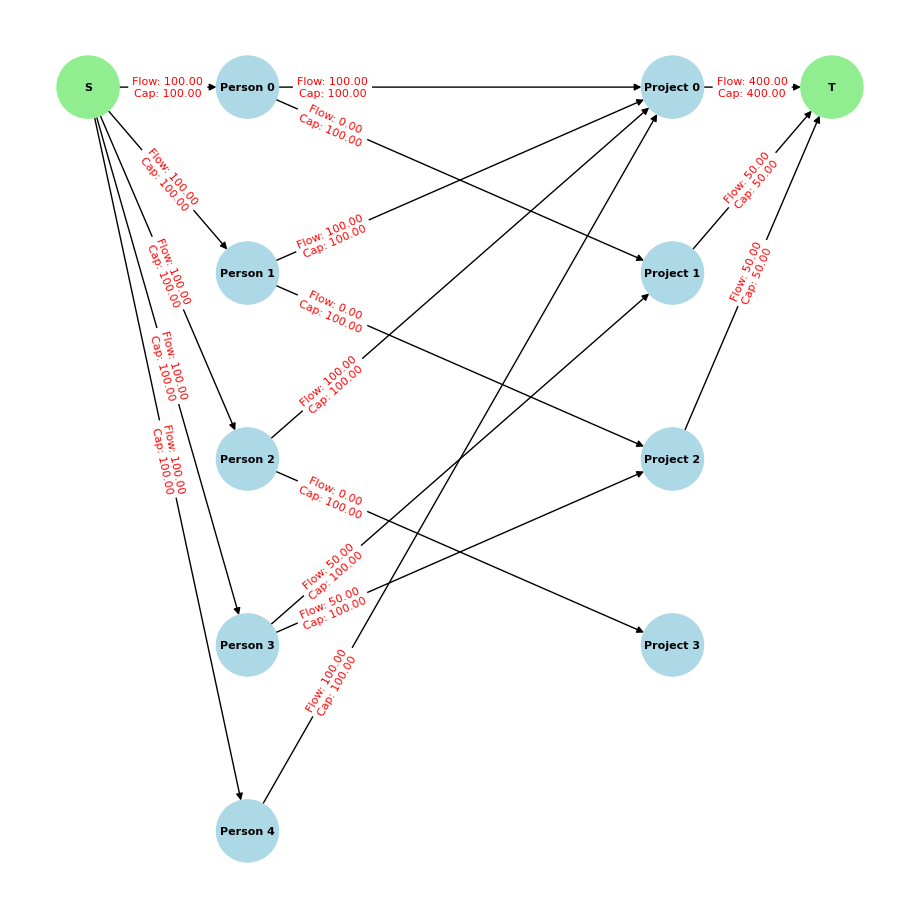

In [2]:
run_example(
    "Example 1",
    budget=[400, 50, 50, 0],
    preferences=[{0, 1}, {0, 2}, {0, 3}, {1, 2}, {0}]
)


Example 2:
No valid decomposition.
Flow achieved: 400.00
Required flow: 500.00

Contribution Table:
               Project 1  Project 2  Project 3  Project 4  Sum (Citizen)
Citizen 1          100.0        0.0        0.0        0.0          100.0
Citizen 2          100.0        0.0        0.0        0.0          100.0
Citizen 3          100.0        0.0        0.0        0.0          100.0
Citizen 4            0.0        0.0       50.0        0.0           50.0
Citizen 5            0.0       50.0        0.0        0.0           50.0
Sum (Project)      300.0       50.0       50.0        0.0          400.0


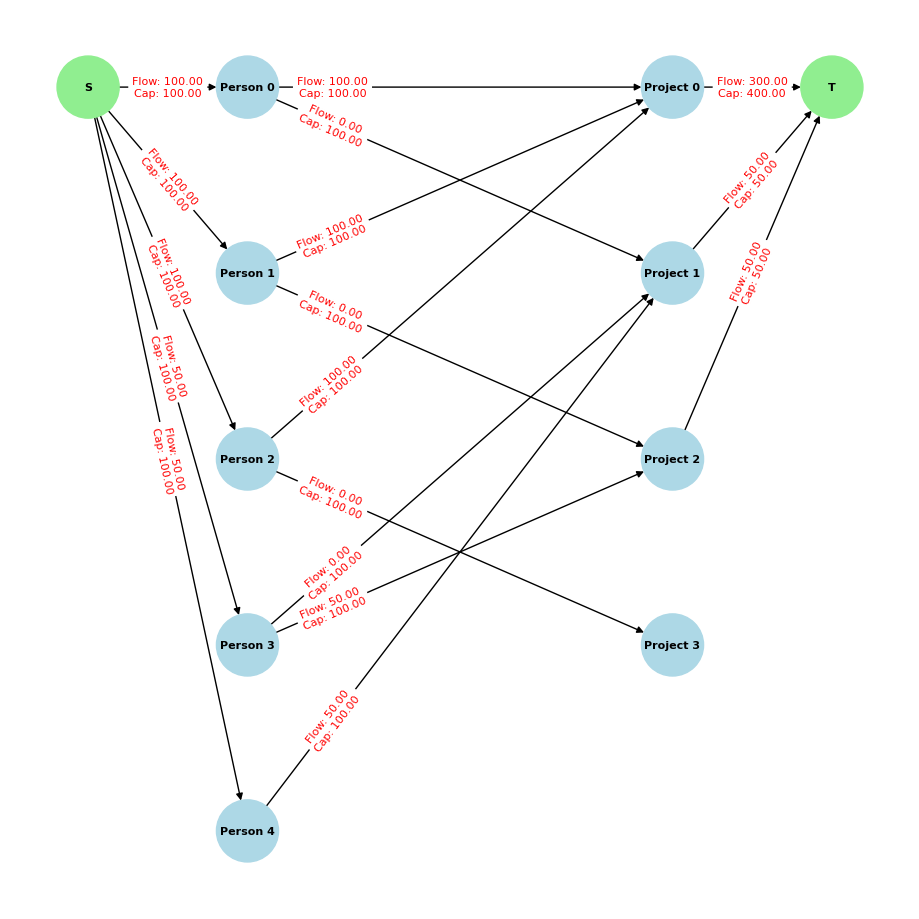

In [3]:
run_example(
    "Example 2",
    budget=[400, 50, 50, 0],
    preferences=[{0, 1}, {0, 2}, {0, 3}, {1, 2}, {1}]
)


Example 3:
A valid decomposition exists!
Flow achieved: 1000.00
Required flow: 1000.00

Contribution Table:
               Project 1   Project 2   Project 3  Sum (Citizen)
Citizen 1          300.0   33.333333    0.000000     333.333333
Citizen 2            0.0  266.666667   66.666667     333.333333
Citizen 3            0.0    0.000000  333.333333     333.333333
Sum (Project)      300.0  300.000000  400.000000    1000.000000


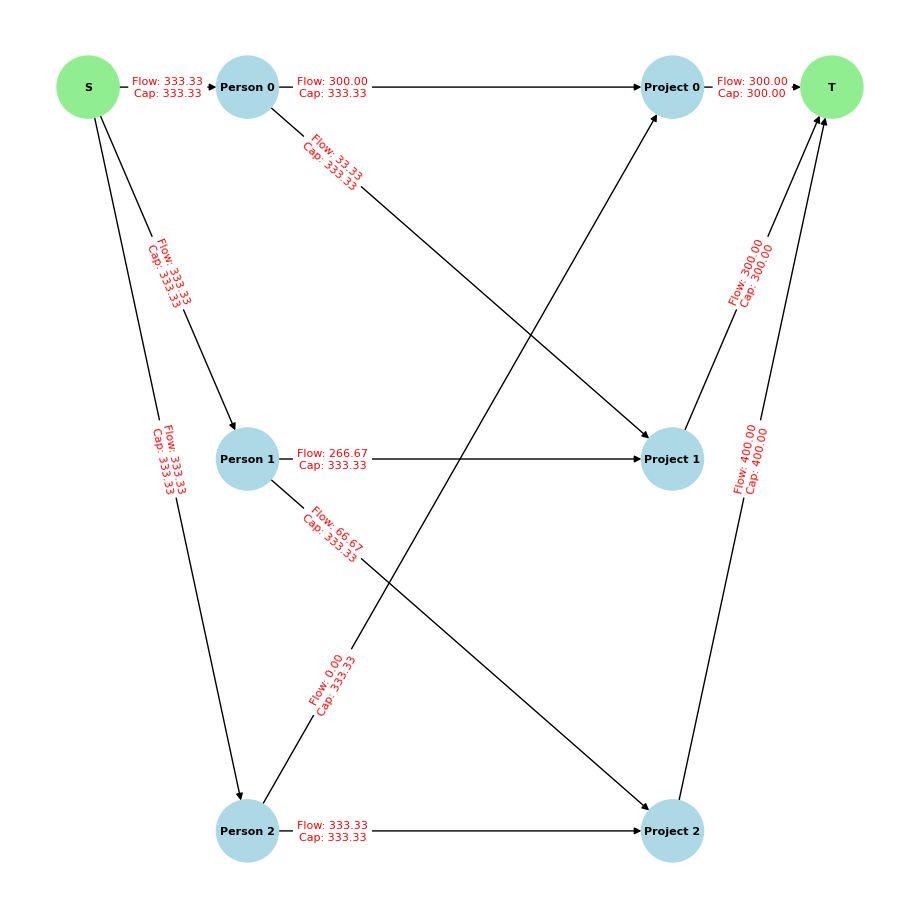

In [4]:
run_example(
    "Example 3",
    budget=[300, 300, 400],
    preferences=[{0, 1}, {1, 2}, {0, 2}]
)


Example 4:
No valid decomposition.
Flow achieved: 300.00
Required flow: 600.00

Contribution Table:
               Project 1  Project 2  Project 3  Sum (Citizen)
Citizen 1          100.0        0.0        0.0          100.0
Citizen 2            0.0        0.0        0.0            0.0
Citizen 3            0.0      200.0        0.0          200.0
Sum (Project)      100.0      200.0        0.0          300.0


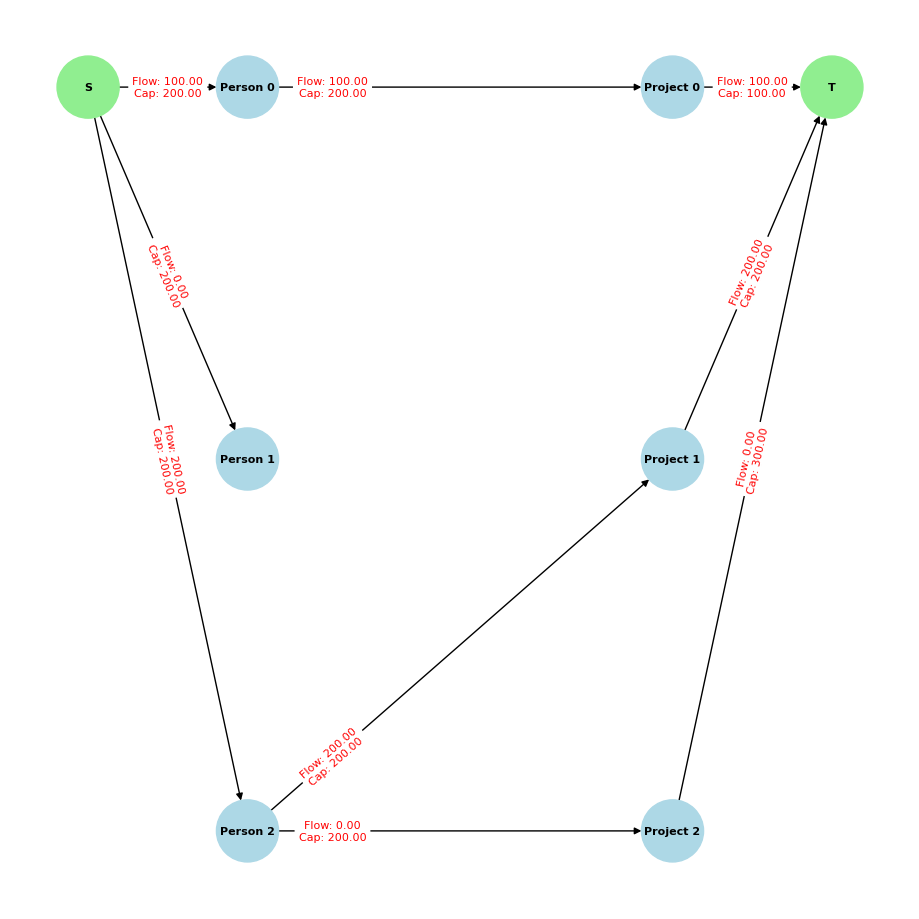

In [5]:
run_example(
    "Example 4",
    budget=[100, 200, 300],
    preferences=[{0}, set(), {1, 2}]
)


Example 5:
A valid decomposition exists!
Flow achieved: 250.00
Required flow: 250.00

Contribution Table:
                Project 1   Project 2  Sum (Citizen)
Citizen 1       83.333333    0.000000      83.333333
Citizen 2        0.000000   83.333333      83.333333
Citizen 3       16.666667   66.666667      83.333333
Sum (Project)  100.000000  150.000000     250.000000


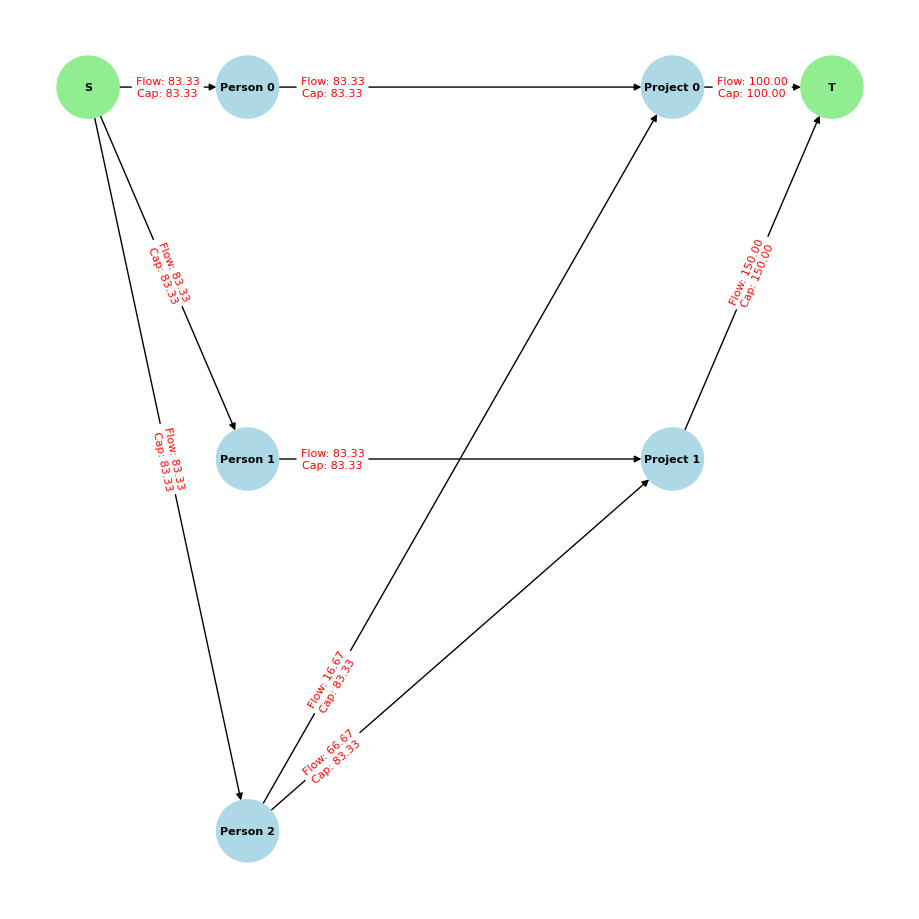

In [6]:
run_example(
    "Example 5",
    budget=[100, 150],
    preferences=[{0}, {1}, {0, 1}]
)


Example 6:
A valid decomposition exists!
Flow achieved: 100.00
Required flow: 100.00

Contribution Table:
               Project 1  Sum (Citizen)
Citizen 1          100.0          100.0
Sum (Project)      100.0          100.0


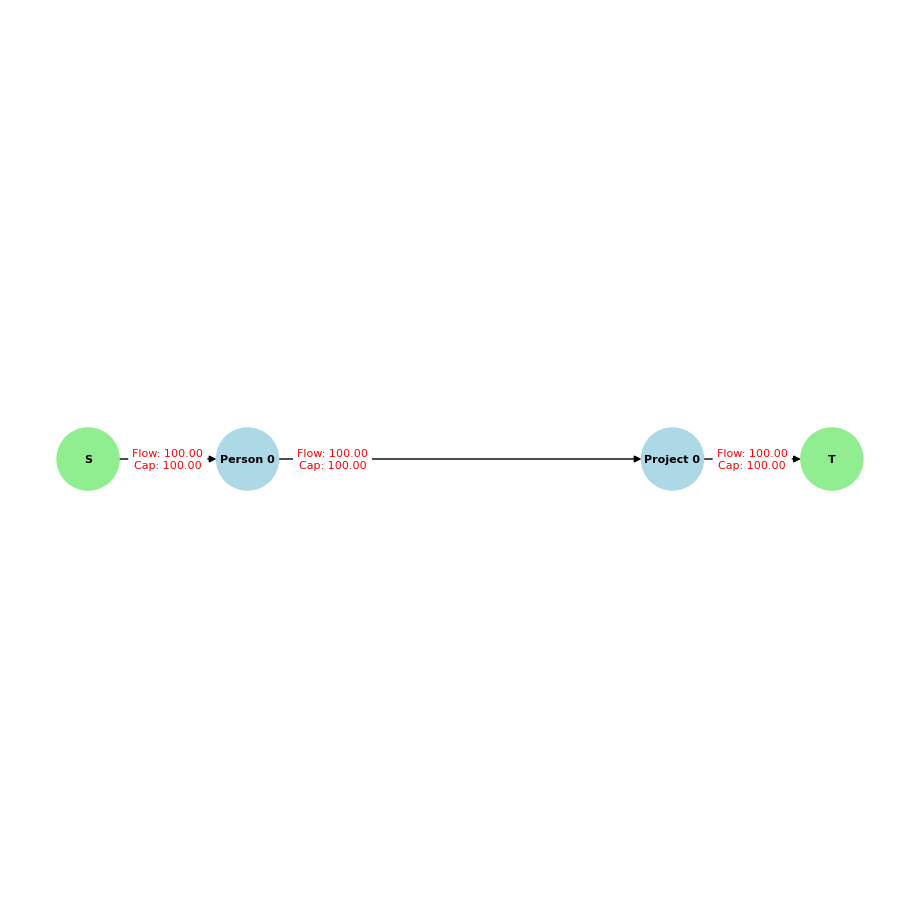

In [7]:
run_example(
    "Example 6",
    budget=[100],
    preferences=[{0}]
)


Example 7:
A valid decomposition exists!
Flow achieved: 600.00
Required flow: 600.00

Contribution Table:
               Project 1  Project 2  Project 3  Sum (Citizen)
Citizen 1            0.0        0.0      200.0          200.0
Citizen 2            0.0      100.0      100.0          200.0
Citizen 3          100.0      100.0        0.0          200.0
Sum (Project)      100.0      200.0      300.0          600.0


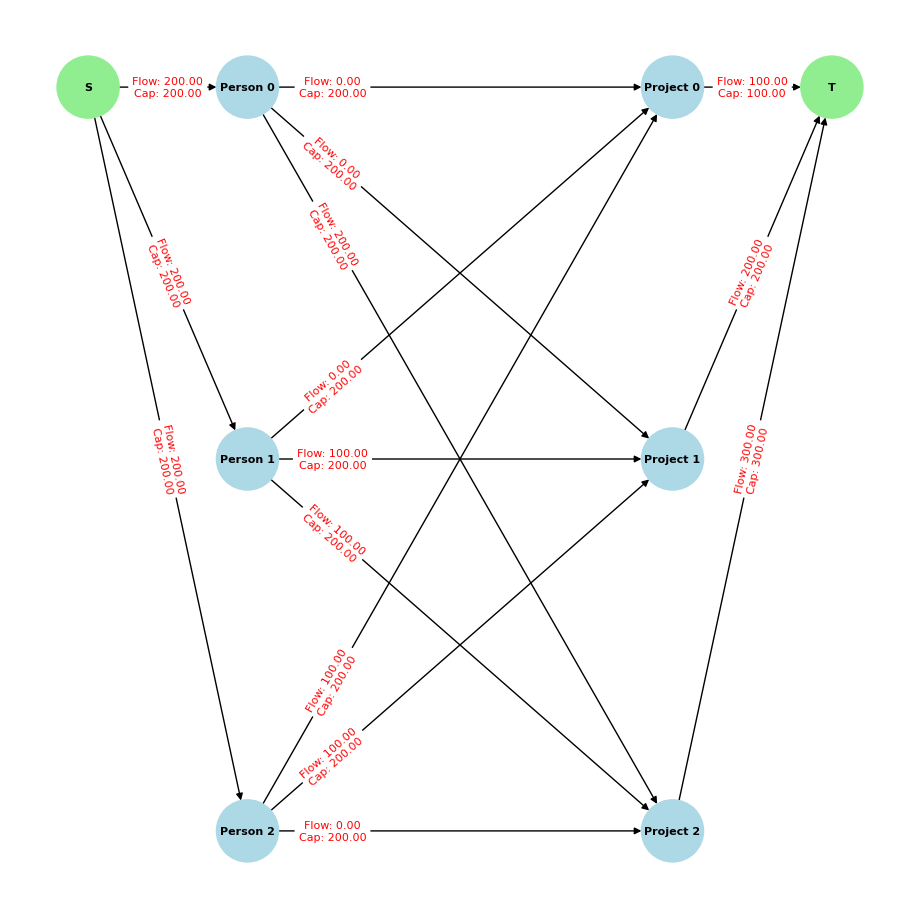

In [8]:
run_example(
    "Example 7",
    budget=[100, 200, 300],
    preferences=[{0, 1, 2}, {0, 1, 2}, {0, 1, 2}]
)